# Phandelver Probabilities

Let's use the Python programming language to explore some of the dice roll probabilities in a D&D 5e adventure. I personnally find math easier to understand when it's expressed as Python code and I want to improve my familiarity with plotting (graphing) using the `matplotlib` Python library.


## Setup


### D&D Specifics

We'll be looking at the first encounter of the _Lost Mine of Phandelver_ adventure using the pregenerated characters (see **Notes and References**, below).


### Python Imports and Globals

First we'll load the Python imports and globals:

In [1]:
# Standard library
from itertools import product
from statistics import fmean

# Third-party
import matplotlib.pyplot as plot
import matplotlib.ticker as ticker
import numpy

%matplotlib inline
plot.style.use("ggplot")

### Probability

The basic formula for probability is the frequency (identified outcomes) divided by the total possible outcomes. For example

In [2]:
frequency = 1  # any given number on a d20 occurs once
total_possible_outcomes = 20  # there are 20 sides
print(
    "Rolling any given number on a d20 has a probability of:"
    f" {frequency}/{total_possible_outcomes} or"
    f" {int(frequency / total_possible_outcomes * 100)}%"
)

Rolling any given number on a d20 has a probability of: 1/20 or 5%


### Dice Numpy Arrays

We can use the `numpy` library to make things easier for ourselves. Its array objects work very nicely with plotting and we can quickly generate the range of numbers used by dice using its functions:

In [3]:
def dice(formula):
    """
    Create numpy array from dice formula (example: 3d6 + 2)
    """
    modifier = 0
    count, faces = formula.split("d")
    if not count:
        count = 1
    else:
        count = int(count.strip())
    if "+" in faces:
        faces, modifier = faces.split("+")
        modifier = int(modifier.strip())
    elif "-" in faces:
        faces, modifier = faces.split("-")
        modifier = int(f"-{modifier.strip()}")
    faces = int(faces.strip())
    array = numpy.arange(
        (1 * count) + modifier, (faces * count) + modifier + 1
    )
    return array


d4 = dice("d4")
d6 = dice("d6")
d8 = dice("d8")
d12 = dice("d12")
d20 = dice("d20")

### Simple Plot

The probability plot of a single dice roll is fairly boring:

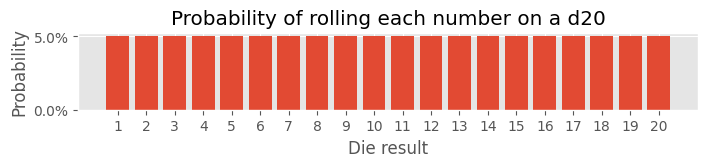

In [4]:
# d20 defined above

# Determine frequency of each number (will return an array contain twenty 1s)
frequency = numpy.unique(d20, return_counts=True)[1]
# Create probability array for rolling each number
probability = (frequency / len(d20)) * 100

# Initialize plot
fig, ax = plot.subplots()
fig.set_size_inches(8, 1)

# reate bar plot for result probability of a normal d20 roll
ax.bar(d20, probability)

# Configure Title
ax.set_title("Probability of rolling each number on a d20")
# Confgure X Axis
ax.set_xlabel("Die result")
ax.xaxis.set_major_locator(ticker.FixedLocator(d20))
# Configure Y Axis
ax.set_ylabel("Probability")
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

## Ability Checks

It's a little more interesting, however, if we plot the chance of exceeding a number when rolling a d20. In D&D 5e the number that must be matched or exceeded is the Difficulty Class (DC). It's also worth noting that Armor Class (AC) is simply a specific type of DC. More interesting still are the probability plots for rolls with [advantage and disadvantage](https://www.dndbeyond.com/sources/basic-rules/using-ability-scores#AdvantageandDisadvantage):

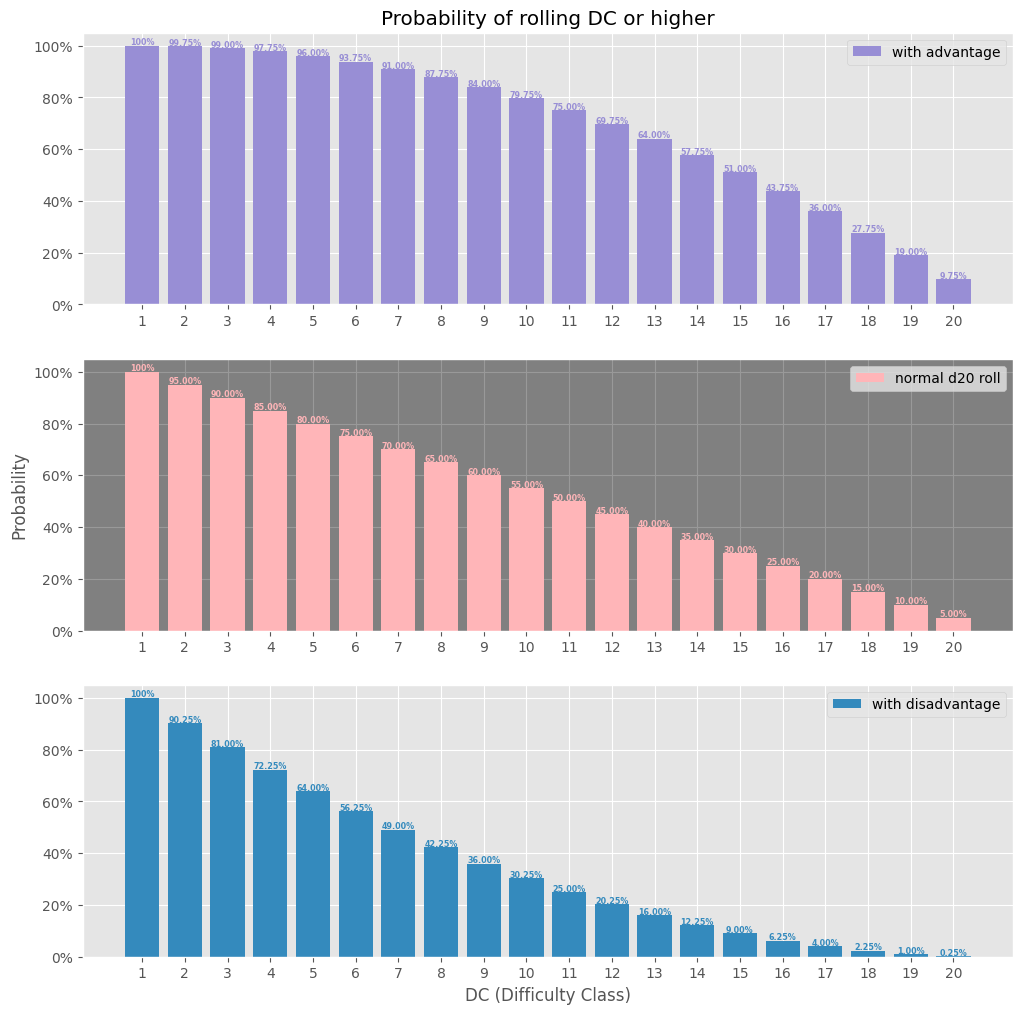

In [5]:
# d20 defined above


def annotate(ax, index, probability, color):
    """
    Annotate top of bar plot with exact probability percentage
    """
    if probability >= 100.0:
        text = f"{probability:0.0f}%"
    else:
        text = f"{probability:0.2f}%"
    ax.annotate(
        text,
        (index, probability + 0.4),
        color=color,
        fontsize="xx-small",
        fontweight="bold",
        horizontalalignment="center",
        zorder=5,
    )


# Create probability array for rolling DC or higher with advantage
advantage_roll = ((len(d20) ** 2 - (d20 - 1) ** 2) / len(d20) ** 2) * 100
# Create probability array for rolling DC or higher on a d20
normal_roll = ((len(d20) - (d20 - 1)) / len(d20)) * 100
# Create probability array for rolling DC or higher with disadvantage
disadvantage_roll = (((len(d20) - (d20 - 1)) ** 2) / len(d20) ** 2) * 100

# Initialize plot
fig, axs = plot.subplots(3, 1)
(ax1, ax2, ax3) = axs
fig.set_size_inches(12, 12)

# Create bar plot and annotation for success probability with advantage
ax1.bar(d20, advantage_roll, color="C2", label="with advantage")
for i, probability in enumerate(advantage_roll):
    annotate(ax1, d20[i], probability, "C2")
# Create bar plot and annotation for success probability of a normal d20 roll
ax2.bar(d20, normal_roll, color="C6", label="normal d20 roll")
for i, probability in enumerate(normal_roll):
    annotate(ax2, d20[i], probability, "C6")
# Create bar plot and annotation for success probability with disadvantage
ax3.bar(d20, disadvantage_roll, color="C1", label="with disadvantage")
for i, probability in enumerate(disadvantage_roll):
    annotate(ax3, d20[i], probability, "C1")

# Configure Title
ax1.set_title("Probability of rolling DC or higher")
# Confgure X Axis
for ax in axs:
    ax.xaxis.set_major_locator(ticker.FixedLocator(d20))
ax.xaxis.set_tick_params(which="minor", length=4, colors="gray")
ax3.set_xlabel("DC (Difficulty Class)")
# Configure Y Axis
ax2.set_ylabel("Probability")
for ax in axs:
    ax.yaxis.set_major_formatter(ticker.PercentFormatter())
# Configure middle plot background and grid color
ax2.grid(color="0.6")
ax2.set_facecolor("0.5")
# Configure Legend for each axis
for ax in axs:
    ax.legend()

Or all together:

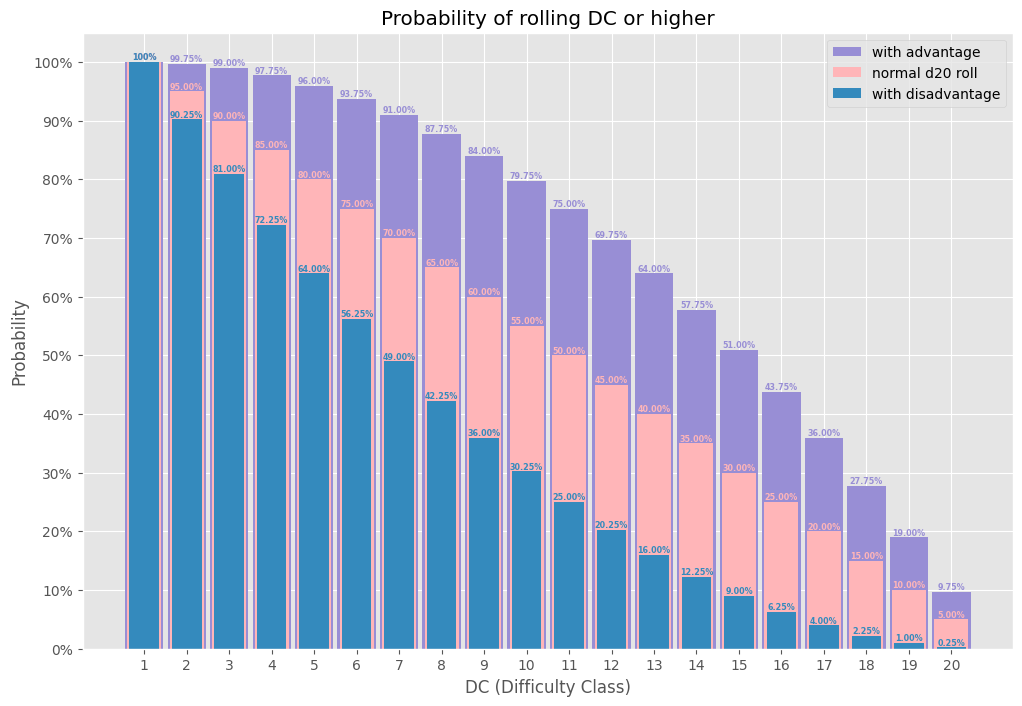

In [6]:
# annotate(), d20, advantage_roll, normal_roll, and disadvantage_roll defined above

# Initialize plot
fig, ax = plot.subplots()
fig.set_size_inches(12, 8)

# Create bar plot for success probability with advantage
ax.bar(d20, advantage_roll, width=0.9, color="C2", label="with advantage")
for i, probability in enumerate(advantage_roll):
    annotate(ax, d20[i], probability, "C2")
# Create bar plot for success probability of a normal d20 roll
ax.bar(d20, normal_roll, width=0.8, color="C6", label="normal d20 roll")
for i, probability in enumerate(normal_roll):
    annotate(ax, d20[i], probability, "C6")
# Create bar plot for success probability with disadvantage
ax.bar(
    d20, disadvantage_roll, width=0.7, color="C1", label="with disadvantage"
)
for i, probability in enumerate(disadvantage_roll):
    annotate(ax, d20[i], probability, "C1")

# Configure Title
ax.set_title("Probability of rolling DC or higher")
# Confgure X Axis
ax.set_xlabel("DC (Difficulty Class)")
ax.xaxis.set_major_locator(ticker.FixedLocator(d20))
# Configure Y Axis
ax.set_ylabel("Probability")
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
# Configure Legend
ax.legend()

## Goblin Ambush

Four [goblins](https://www.dndbeyond.com/monsters/16907-goblin) attempt to ambush the party. Their stealth modifier is +6 vs the party's passive perception. Will they surprise everyone in the party?

(0.0, 31.5)

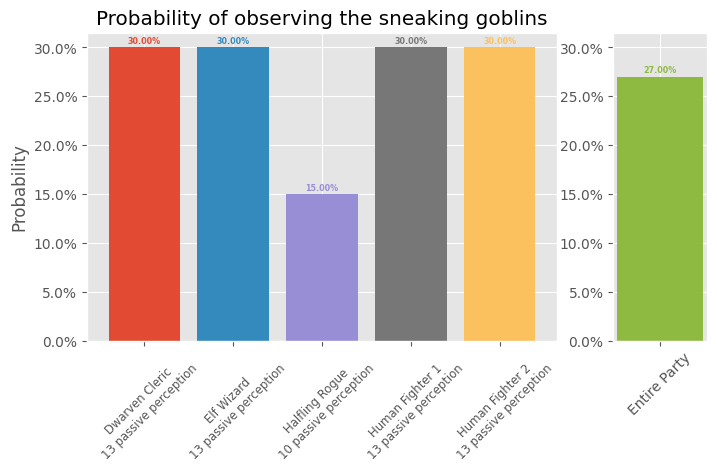

In [7]:
# d20 and normal_roll defined above


def get_success_chance(dc, modifier):
    """
    Determine probibility of success for a given DC with a modifier d20 roll.
    """
    # Create probability array for rolling DC or higher on a d20
    keys = d20 + modifier
    if keys[0] > dc:
        chance = 100
    elif keys[-1] < dc:
        chance = 0
    index = keys.tolist().index(dc)
    return normal_roll[index]


goblin_stealth_modifier = 6
player_names = [
    "Dwarven Cleric\n13 passive perception",
    "Elf Wizard\n13 passive perception",
    "Halfling Rogue\n10 passive perception",
    "Human Fighter 1\n13 passive perception",
    "Human Fighter 2\n13 passive perception",
]
players_passive_perception = [13, 13, 10, 13, 13]
players_observation_chance = []
for i, passive_perception in enumerate(players_passive_perception):
    observation_chance = 100 - get_success_chance(
        passive_perception, goblin_stealth_modifier
    )
    players_observation_chance.append(observation_chance)
party_observation_chance = fmean(players_observation_chance)

# Initialize plot
fig, axs = plot.subplots(1, 2, width_ratios=[5, 1])
(ax1, ax2) = axs
fig.set_size_inches(8, 4)

# Create bar plot and annotation for observation probability of each player
for i, observation_chance in enumerate(players_observation_chance):
    ax1.bar(i, observation_chance)
    annotate(ax1, i, observation_chance, f"C{i}")

# Create bar plot and annotation for observation probability of entire party
ax2.bar(0, party_observation_chance, color="C5")
annotate(ax2, 0, party_observation_chance, "C5")

# Configure Title
ax1.set_title("Probability of observing the sneaking goblins")
# Confgure X Axis
ax1.xaxis.set_major_locator(ticker.FixedLocator(range(len(player_names) + 1)))
ax1.xaxis.set_major_formatter(ticker.FixedFormatter(player_names))
ax1.xaxis.set_tick_params(labelrotation=45, labelsize="small")
ax2.xaxis.set_major_locator(ticker.FixedLocator([0]))
ax2.xaxis.set_major_formatter(ticker.FixedFormatter(["Entire Party"]))
ax2.xaxis.set_tick_params(labelrotation=45, labelsize="medium")
# Configure Y Axis
ax1.set_ylabel("Probability")
ax1.yaxis.set_major_formatter(ticker.PercentFormatter())
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
ax2.set_ylim(ax1.get_ylim())  # use same scale for both axes

## Initiative Rolls

Initiative, for everyone involved in this encounter, uses a single die with a flat probability plot (boring). However, I think the comparison between characters is interesting:

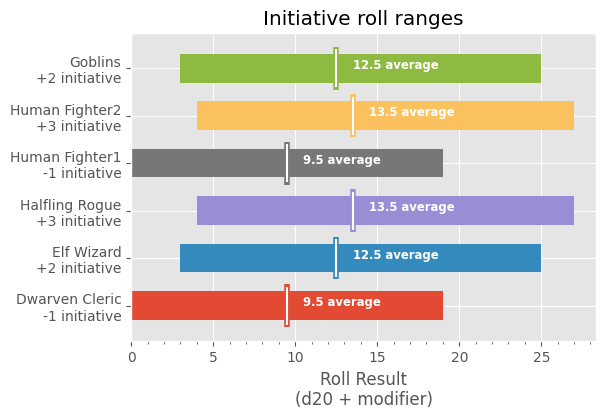

In [8]:
# d20 defined above

initiative = [
    # Character, Initiative
    ("Dwarven Cleric\n-1 initiative", -1),
    ("Elf Wizard\n+2 initiative", 2),
    ("Halfling Rogue\n+3 initiative", 3),
    ("Human Fighter1\n-1 initiative", -1),
    ("Human Fighter2\n+3 initiative", 3),
    ("Goblins\n+2 initiative", 2),
]

initiative_arrays = []
for _, modifier in initiative:
    initiative_arrays.append(d20 + modifier)

# Initialize plot
fig, ax = plot.subplots()
fig.set_size_inches(6, 4)

for i, array in enumerate(initiative_arrays):
    x = i + 1
    ax.barh(x, array, height=0.6, left=array[0])
    ax.vlines(array.mean(), x - 0.45, x + 0.45, color=f"C{i}", linewidth=4.0)
    ax.vlines(array.mean(), x - 0.4, x + 0.4, color="white")
    ax.annotate(
        f"{array.mean()} average",
        (array.mean() + 1, x),
        color="white",
        fontsize="small",
        fontweight="bold",
        horizontalalignment="left",
    )

# Configure Title
ax.set_title("Initiative roll ranges")
# Confgure X Axis
ax.set_xlabel("Roll Result\n(d20 + modifier)")
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
# Configure Y Axis
ax.yaxis.set_major_locator(
    ticker.FixedLocator(range(len(initiative_arrays) + 1))
)
ax.yaxis.set_major_formatter(
    ticker.FixedFormatter([""] + [item[0] for item in initiative])
)

## Damage Rolls

With initiative order established, let us investigate the more interesting damage probabilities. We'll only explore the specific damage rolls with interesting (not flat) plots. Last we'll compare damage ranges and averages.

### Hafling Rogue

The Halfling Rogue can do sneak attack damage when a fellow party member is adjancent to their target:

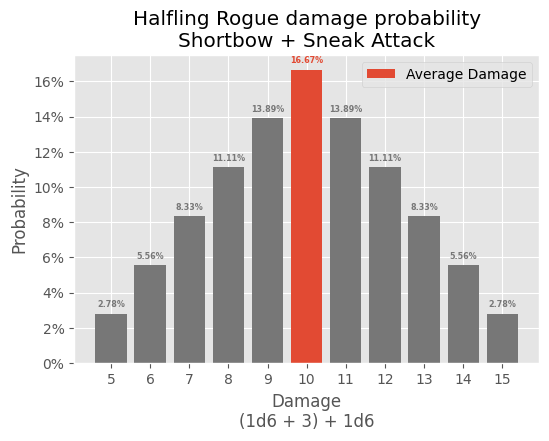

In [9]:
# d6 defined above

# Create datasets
proficiency_modifier = 1
dexterity_modifier = 2
modifier = proficiency_modifier + dexterity_modifier
d6_plus_mod = d6 + modifier
counts = []
for combination in product(d6_plus_mod, d6):
    counts.append(sum(combination))
counts.sort()
average_damage = int(numpy.array(counts).mean())
results = numpy.array(sorted(list(set(counts))))

# Initialize plot
fig, ax = plot.subplots()
fig.set_size_inches(6, 4)

probability_total = 0
for result in results:
    if result == average_damage:
        label = "Average Damage"
        color = "C0"
    else:
        label = None
        color = "C3"
    damage_probability = (counts.count(result) / len(d6_plus_mod) ** 2) * 100
    probability_total += damage_probability
    ax.bar(result, damage_probability, color=color, label=label)
    annotate(ax, result, damage_probability, color)

# Configure Title
ax.set_title("Halfling Rogue damage probability\nShortbow + Sneak Attack")
# Confgure X Axis
ax.set_xlabel("Damage\n(1d6 + 3) + 1d6")
ax.xaxis.set_major_locator(ticker.FixedLocator(results))
# Confgure Y Axis
ax.set_ylabel("Probability")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
# Configure Legend
ax.legend()
# check probability for errors
if probability_total > 100.001:
    print("ERROR: total damage probability:", probability_total)

### Elf Wizard

The Elf Wizard has more interesting attacks in terms of probability. First, we'll investigate the damage probability of the [Magic Missile](https://www.dndbeyond.com/spells/magic-missile) spell at 1st level:

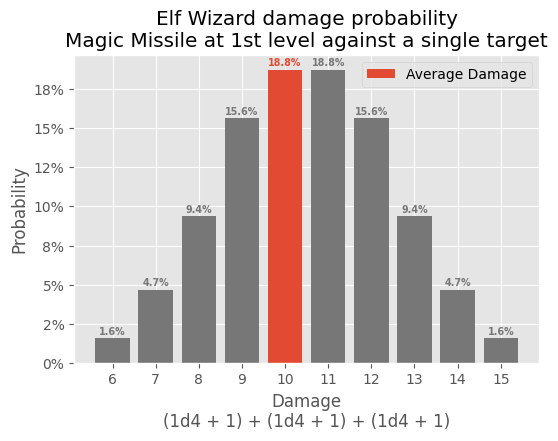

In [10]:
# d4 defined above

# Create datasets
d4_plus_mod = d4 + 1
counts = []
for combination in product(d4_plus_mod, d4_plus_mod, d4_plus_mod):
    counts.append(sum(combination))
counts.sort()
average_damage = int(numpy.array(counts).mean())
results = numpy.array(sorted(list(set(counts))))

# Initialize plot
fig, ax = plot.subplots()
fig.set_size_inches(6, 4)

probability_total = 0
for result in results:
    if result == average_damage:
        label = "Average Damage"
        color = "C0"
    else:
        label = None
        color = "C3"
    damage_probability = (counts.count(result) / len(d4_plus_mod) ** 3) * 100
    probability_total += damage_probability
    ax.bar(result, damage_probability, color=color, label=label)
    ax.annotate(
        f"{damage_probability:0.1f}%",
        (result, damage_probability + 0.25),
        color=color,
        fontsize="x-small",
        fontweight="bold",
        horizontalalignment="center",
    )

# Configure Title
ax.set_title(
    "Elf Wizard damage probability\nMagic Missile at 1st level against a"
    " single target"
)
# Confgure X Axis
ax.set_xlabel("Damage\n(1d4 + 1) + (1d4 + 1) + (1d4 + 1)")
ax.xaxis.set_major_locator(ticker.FixedLocator(results))
# Confgure Y Axis
ax.set_ylabel("Probability")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
# Configure Legend
ax.legend()
# check probability for errors
if probability_total > 100.001:
    print("ERROR: total damage probability:", probability_total)

Next, we'll investigate the damage probability if the Elf Wizard casts the [Burning Hands](https://www.dndbeyond.com/spells/burning-hands) spell at 1st level:

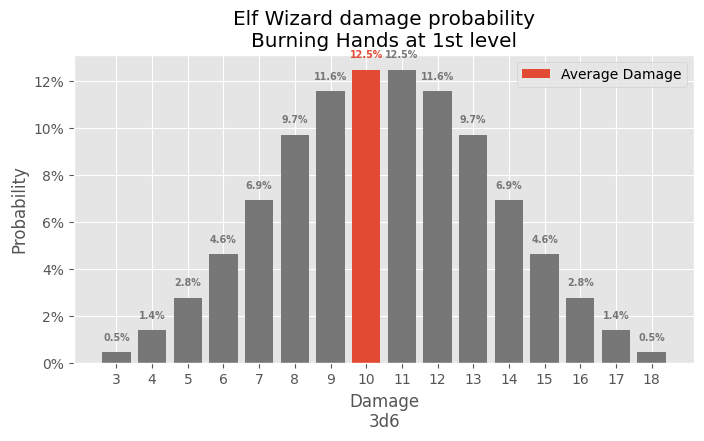

In [11]:
# d6 defined above

# Create datasets
counts = []
for combination in product(d6, d6, d6):
    counts.append(sum(combination))
counts.sort()
average_damage = int(numpy.array(counts).mean())
results = numpy.array(sorted(list(set(counts))))

# Initialize plot
fig, ax = plot.subplots()
fig.set_size_inches(8, 4)

probability_total = 0
for result in results:
    if result == average_damage:
        label = "Average Damage"
        color = "C0"
    else:
        label = None
        color = "C3"
    damage_probability = (counts.count(result) / len(d6) ** 3) * 100
    probability_total += damage_probability
    ax.bar(result, damage_probability, color=color, label=label)
    ax.annotate(
        f"{damage_probability:0.1f}%",
        (result, damage_probability + 0.5),
        color=color,
        fontsize="x-small",
        fontweight="bold",
        horizontalalignment="center",
    )

# Confgure Title
ax.set_title("Elf Wizard damage probability\nBurning Hands at 1st level")
# Confgure X Axis
ax.set_xlabel("Damage\n3d6")
ax.xaxis.set_major_locator(ticker.FixedLocator(results))
# Confgure Y Axis
ax.set_ylabel("Probability")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
# Configure Legend
ax.legend()
# check probability for errors
if probability_total > 100.001:
    print("ERROR: total damage probability:", probability_total)

### Goblins

The total damage of the four [goblins](https://www.dndbeyond.com/monsters/16907-goblin):

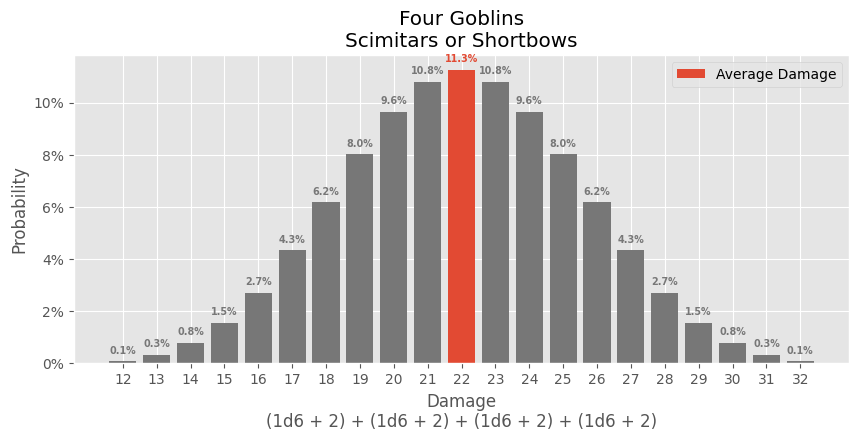

In [12]:
# d6 defined above

# Create datasets
dexterity_modifier = 2
d6_plus_mod = d6 + dexterity_modifier
counts = []
for combination in product(d6_plus_mod, d6_plus_mod, d6_plus_mod, d6_plus_mod):
    counts.append(sum(combination))
counts.sort()
average_damage = int(numpy.array(counts).mean())
results = numpy.array(sorted(list(set(counts))))

# Initialize plot
fig, ax = plot.subplots()
fig.set_size_inches(10, 4)


probability_total = 0
for result in results:
    if result == average_damage:
        label = "Average Damage"
        color = "C0"
    else:
        label = None
        color = "C3"
    damage_probability = (counts.count(result) / len(d6_plus_mod) ** 4) * 100
    probability_total += damage_probability
    ax.bar(result, damage_probability, color=color, label=label)
    ax.annotate(
        f"{damage_probability:0.1f}%",
        (result, damage_probability + 0.3),
        color=color,
        fontsize="x-small",
        fontweight="bold",
        horizontalalignment="center",
    )

# Confgure Title
ax.set_title("Four Goblins\nScimitars or Shortbows")
# Confgure X Axis
ax.set_xlabel("Damage\n(1d6 + 2) + (1d6 + 2) + (1d6 + 2) + (1d6 + 2)")
ax.xaxis.set_major_locator(ticker.FixedLocator(results))
# Confgure Y Axis
ax.set_ylabel("Probability")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
# Configure Legend
ax.legend()
# check probability for errors
if probability_total > 100.001:
    print("ERROR: total damage probability:", probability_total)

### Damage Range Comparisons

Last, let's look at optimal damage comparisons (ignoring criticals, but otherwise assuming the best circumstance for each character or monster group). Note that because of the rule of rounding down, the average damage skews lower.

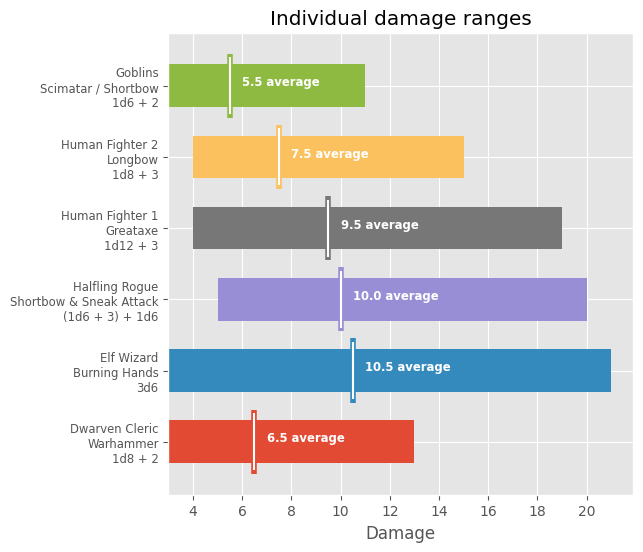

In [13]:
# dice() defined above

# Create dataset: character, damage array
damage = [
    ("Dwarven Cleric\nWarhammer\n1d8 + 2", dice("1d8 + 2")),
    ("Elf Wizard\nBurning Hands\n3d6", dice("3d6")),
    (
        "Halfling Rogue\nShortbow & Sneak Attack\n(1d6 + 3) + 1d6",
        dice("2d6 + 3"),
    ),
    ("Human Fighter 1\nGreataxe\n1d12 + 3", dice("1d12 + 3")),
    ("Human Fighter 2\nLongbow\n1d8 + 3", dice("1d8 + 3")),
    ("Goblins\nScimatar / Shortbow\n1d6 + 2", dice("1d6 + 2")),
]

# Initialize plot
fig, ax = plot.subplots()
fig.set_size_inches(6, 6)

for i, (_, array) in enumerate(damage):
    x = i + 1
    ax.barh(x, array, height=0.6, left=array[0], label="x")
    ax.vlines(array.mean(), x - 0.45, x + 0.45, color=f"C{i}", linewidth=4.0)
    ax.vlines(array.mean(), x - 0.4, x + 0.4, color="white")
    ax.annotate(
        f"{array.mean()} average",
        (array.mean() + 0.5, x),
        color="white",
        fontsize="small",
        fontweight="bold",
        horizontalalignment="left",
    )

# Confgure Title
ax.set_title("Individual damage ranges")
# Confgure X Axis
ax.set_xlabel("Damage")
ax.xaxis.set_major_locator(ticker.MaxNLocator(steps=(2, 10)))
# Confgure Y Axis
ax.yaxis.set_major_locator(
    ticker.FixedLocator(range(len(initiative_arrays) + 1))
)
ax.yaxis.set_major_formatter(
    ticker.FixedFormatter([""] + [item[0] for item in damage])
)
ax.yaxis.set_tick_params(labelsize="small")

The players have the benefit of outnumbering the goblins:

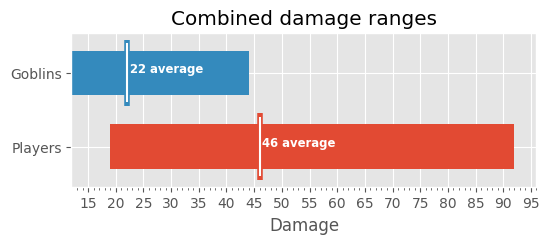

In [14]:
# Create dataset: group, damage array
damage = [
    ("Players", numpy.arange(19, 74)),
    ("Goblins", numpy.arange(12, 33)),
]

# Initialize plot
fig, ax = plot.subplots()
fig.set_size_inches(6, 2)

for i, (_, array) in enumerate(damage):
    x = i + 1
    ax.barh(x, array, height=0.6, left=array[0])
    ax.vlines(array.mean(), x - 0.45, x + 0.45, color=f"C{i}", linewidth=4.0)
    ax.vlines(array.mean(), x - 0.4, x + 0.4, color="white")
    ax.annotate(
        f"{array.mean():0.0f} average",
        (array.mean() + 0.5, x),
        color="white",
        fontsize="small",
        fontweight="bold",
        horizontalalignment="left",
    )

# Confgure Title
ax.set_title("Combined damage ranges")
# Confgure X Axis
ax.set_xlabel("Damage")
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=17, steps=(5, 10)))
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
# Confgure Y Axis
ax.yaxis.set_major_locator(
    ticker.FixedLocator(range(len(initiative_arrays) + 1))
)
ax.yaxis.set_major_formatter(
    ticker.FixedFormatter([""] + [item[0] for item in damage])
)

## Notes and References

- D&D Content
  - [Lost Mine of Phandelver](https://www.dndbeyond.com/sources/lmop) D&D adventure (free, but requires D&D Beyond signup)
    - [Pregenerated Characters](https://www.dndbeyond.com/sources/lmop/introduction#PregeneratedCharacters):
      1. [Dwarven ClericDwarven Cleric (231 KB PDF)](https://www.dndbeyond.com/file-attachments/0/776/dwarf-cleric.pdf)
      2. [Elven Wizard (219 KB PDF)](https://www.dndbeyond.com/file-attachments/0/777/elf-wizard.pdf)
      3. [Halfling Rogue (202 KB PDF)](https://www.dndbeyond.com/file-attachments/0/778/halfling-rogue.pdf)
      4. [Human Fighter 1 (189 KB PDF)](https://www.dndbeyond.com/file-attachments/0/779/human-fighter.pdf)
      5. [Human Fighter 2 (188 KB PDF)](https://www.dndbeyond.com/file-attachments/0/780/human-fighter2.pdf)
- D&D Rules
  - [Round Down - Basic Rules for Dungeons and Dragons (D&D) Fifth Edition (5e) - D&D Beyond](https://www.dndbeyond.com/sources/basic-rules/introduction#RoundDown)
  - [Advantage and Disadvantage - Basic Rules for Dungeons and Dragons (D&D) Fifth Edition (5e) - D&D Beyond](https://www.dndbeyond.com/sources/basic-rules/using-ability-scores#AdvantageandDisadvantage)
- D&D and Probability
  - [[5e] The math and probability behind rolling with advantage! : DnD](https://www.reddit.com/r/DnD/comments/802zzo/comment/dusrx2d/)
  - [D&D Probability distributionsD&D Probability distributions](https://www.cl.cam.ac.uk/~rmk35/dropbears.html) (tabular data is inaccurate--off by 1)
  - [I made a probability calculator for DnD dice rolls! : DungeonsAndDragons](https://www.reddit.com/r/DungeonsAndDragons/comments/uupw5t/i_made_a_probability_calculator_for_dnd_dice_rolls/)
  - [Comment - DnD has led me to discover a rule of probability and I feel like Blaise Pascal : DnD](https://www.reddit.com/r/DnD/comments/i36b8b/comment/g0a72bv/) (more complex problems may require simulation instead of maths)
- JupyterLab
  - [Jupyter Project Documentation](https://docs.jupyter.org/en/latest/)
  - [ryantam626/jupyterlab_code_formatter](https://github.com/ryantam626/jupyterlab_code_formatter) (note that the extension is configured in Jupyter Lab, not config files)
- Matplotlib
  - [Matplotlib documentation](https://matplotlib.org/stable/index.html)
- NumPy
  - [NumPy user guide — NumPy Manual](https://numpy.org/doc/stable/user/index.html#user)
- Python Documentation
  - [itertools — Functions creating iterators for efficient looping — Python 3.10.9 documentation](https://docs.python.org/3.10/library/itertools.html)